In [2]:
from snake import Game
import random
import pygame
import math

# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if GPU is to be used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def epsilon_greedy(obs):
    # epsilon decay policy
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
        math.exp(-1 * episodes_done / epsilon_decay)

    global epsilon_hist
    if len(epsilon_hist) == 0 or epsilon != epsilon_hist[-1]:
        epsilon_hist.append(epsilon)
    print(epsilon)

    # epsilon greedy policy
    sample = random.random()
    if sample > epsilon:
        # print('exploitation')
        with torch.no_grad():
            return torch.argmax(policy_net(obs)).item()

    else:
        # print('exploration')
        rand_action = random.randint(0,3)
        return rand_action

def dist(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def observation(game):
    red = pygame.Color(255, 0, 0)
    orange = pygame.Color(255, 127, 0)
    yellow =pygame.Color(255, 255, 0)
    green = pygame.Color(0, 255, 0)
    blue = pygame.Color(0, 0, 255)
    indigo = pygame.Color(75, 0, 130)
    violet = pygame.Color(148, 0, 211)
    rainbow = [red, orange, yellow, green, blue, indigo, violet]

    # [x_snake, y_snake, up, down, left, right, 
    # distance to top wall, d to bot wall, d to left wall, d to r wall
    # closest seg up, c seg down, c seg left, c seg right
    # red fruit x, red fruit y, o fruit x, o fruit y, y fruit x, y fruit y
    # g fruit x, g fruit y, ...]

    obs_vector = torch.zeros(28)

    snake_body = game.snake_body

    # x and y snake head pos
    obs_vector[0] = game.snake_position[0]
    obs_vector[1] = game.snake_position[1]

    # up down left right
    if game.direction == 'UP':
        obs_vector[2] = 1
    if game.direction == 'DOWN':
        obs_vector[3] = 1
    if game.direction == 'LEFT':
        obs_vector[4] = 1
    if game.direction == 'RIGHT':
        obs_vector[5] = 1

    obs_vector[6] = game.snake_position[0] - 0
    obs_vector[7] = game.window_x - game.snake_position[0]
    obs_vector[8] = game.snake_position[1] - 0
    obs_vector[9] = game.window_y - game.snake_position[1]

    # closest seg up, c seg down, c seg left, c seg right
    gx, gy = game.snake_position

    up_candidates = [p for p in snake_body if p[0] == gx and p[1] > gy]
    down_candidates = [p for p in snake_body if p[0] == gx and p[1] < gy]
    left_candidates = [p for p in snake_body if p[1] == gy and p[0] < gx]
    right_candidates = [p for p in snake_body if p[1] == gy and p[0] > gx]

    # print(up_candidates, down_candidates, left_candidates, right_candidates)

    if len(up_candidates) > 0:
        closest_up = up_candidates[0]
        for pos in up_candidates:
            if dist(gx, gy, closest_up[0], closest_up[1]) < dist(gx, gy, pos[0], pos[1]):
                closest_up = pos
        obs_vector[10] = dist(gx, gy, closest_up[0], closest_up[1])

    if len(down_candidates) > 0:
        closest_down = down_candidates[0]
        for pos in down_candidates:
            if dist(gx, gy, closest_down[0], closest_down[1]) < dist(gx, gy, pos[0], pos[1]):
                closest_down = pos
        obs_vector[11] = dist(gx, gy, closest_down[0], closest_down[1])

    if len(left_candidates) > 0:
        closest_left = left_candidates[0]
        for pos in left_candidates:
            if dist(gx, gy, closest_left[0], closest_left[1]) < dist(gx, gy, pos[0], pos[1]):
                closest_left = pos
        obs_vector[12] = dist(gx, gy, closest_left[0], closest_left[1])

    if len(right_candidates) > 0:
        closest_right = right_candidates[0]
        for pos in right_candidates:
            if dist(gx, gy, closest_right[0], closest_right[1]) < dist(gx, gy, pos[0], pos[1]):
                closest_right = pos
        obs_vector[13] = dist(gx, gy, closest_right[0], closest_right[1])

    for pos, ind in zip(game.fruit_position, range(14, 28, 2)):
        obs_vector[ind] = pos[0]
        obs_vector[ind + 1] = pos[1]
    
    return obs_vector

def optimize_model(obs, next_obs, terminated, reward, action):

    # Compute Q(s_t, a)
    state_action_values = policy_net(torch.flatten(obs))[action]

    # Compute V(s_{t+1})
    if terminated:
        next_state_values = torch.zeros(n_actions).max()
    else:
        with torch.no_grad():
            next_state_values = target_net(torch.flatten(next_obs)).max()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward

    print(state_action_values, expected_state_action_values)

    # Compute Loss
    loss_function = nn.SmoothL1Loss()   
    loss = loss_function(state_action_values, expected_state_action_values)

    # Optimize model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# hyperparameters
batch_size = None
gamma = 0.99
epsilon = 0.90
epsilon_start = 0.90
epsilon_end = 0.05
epsilon_decay = 90
tau = 0.005
lr = 1e-3

# action space and observation space size
x_window_size = 720
y_window_size = 480
x_axis_size = int(x_window_size / 10)
y_axis_size = int(y_window_size / 10)
n_actions = 4  # up down left right
n_observations = 28  # length of obs vectpr

# initialize neural networks
policy_net = DQN(n_observations, n_actions)  #.to(device)
target_net = DQN(n_observations, n_actions)  #.to(device)

# set target net to have the same weights as policy net
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)

# create a steps counter
steps_done = 0
episodes_done = 0
n_episodes = 500

# history
epsilon_hist = []
reward_hist = []

for ep in range(n_episodes):
    game = Game(x_window_size, y_window_size, episodes_done)
    obs = observation(game)

    reward_hist.append(0)

    while True:

        # select action
        action = epsilon_greedy(torch.flatten(obs))

        # save old score
        old_score = game.score

        # print(action)

        # game step
        terminated = game.step(action)

        # get new observation
        if terminated:
            new_obs = None
        else:
            new_obs = observation(game)

        # get new reward
        if terminated:
            reward = -50
        elif old_score < game.score:
            reward = 100
        else:
            red = pygame.Color(255, 0, 0)
            orange = pygame.Color(255, 127, 0)
            yellow =pygame.Color(255, 255, 0)
            green = pygame.Color(0, 255, 0)
            blue = pygame.Color(0, 0, 255)
            indigo = pygame.Color(75, 0, 130)
            violet = pygame.Color(148, 0, 211)
            rainbow = [red, orange, yellow, green, blue, indigo, violet]

            for ind, color in enumerate(rainbow):
                if game.snake_colors[-1] == color:
                    old_dist = dist(obs[0], obs[1], game.fruit_position[ind][0], game.fruit_position[ind][0])
                    new_dist = dist(new_obs[0], new_obs[1], game.fruit_position[ind][0], game.fruit_position[ind][0])
                    if new_dist < old_dist:
                        reward = 1
                    elif new_dist == old_dist:
                        reward = 0
                    else:
                        reward = -0.5


        # update reward history
        reward_hist[-1] += reward

        print(new_obs)

        # break
        reward = torch.tensor(reward)

        # step of optimization
        optimize_model(obs, new_obs, terminated, reward, action)
        
        # update obs
        obs = new_obs

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        target_net.load_state_dict(target_net_state_dict)

        if terminated:
            episodes_done += 1
            break
    
torch.save(policy_net, 'policy2.pth')

0.9
tensor([110., 240.,   0.,   0.,   0.,   1., 110., 610., 240., 240.,   0.,   0.,
         30.,   0., 560., 230.,  40., 210., 470.,  40., 270., 320., 480., 290.,
        410.,  10., 680., 380.])
torch.Size([])
0.9
tensor([100., 230.,   1.,   0.,   0.,   0., 100., 620., 230., 250.,  10.,   0.,
          0.,   0., 140., 260., 250., 440., 580., 180.,  10., 220., 100., 190.,
        330., 340.,  40., 430.])
torch.Size([])
0.9
tensor([110., 240.,   0.,   0.,   0.,   1., 110., 610., 240., 240.,   0.,   0.,
         30.,   0., 700., 470., 400., 190., 290., 410., 690., 270., 320., 340.,
         50., 130.,  70., 120.])
torch.Size([])
0.9
tensor([100., 250.,   0.,   1.,   0.,   0., 100., 620., 250., 230.,   0.,  10.,
          0.,   0., 510., 120., 290., 130., 350., 470., 640., 240., 320., 350.,
        560., 450., 180., 270.])
torch.Size([])
0.9
tensor([100., 250.,   0.,   1.,   0.,   0., 100., 620., 250., 230.,   0.,  10.,
          0.,   0., 560., 390., 320.,  70., 450., 100., 230.,  90., 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
epsilon_hist

[0.9,
 0.8790134252240828,
 0.858545010825607,
 0.8385819633792699,
 0.8191118053305656,
 0.8001223671969062,
 0.7816017799612992,
 0.7635384676538263,
 0.7459211401162845,
 0.7287387859454705,
 0.7119806656106942,
 0.6956363047412232,
 0.6796954875794602,
 0.6641482505957614,
 0.6489848762609065,
 0.6341958869723264,
 0.6197720391302934,
 0.6057043173603702,
 0.5919839288785074,
 0.5786022979952672,
 0.5655510607557385,
 0.5528220597117929,
 0.5404073388234136,
 0.5282991384859124,
 0.5164898906799226,
 0.5049722142411417,
 0.4937389102468636,
 0.48278295751641676,
 0.4720975082226981,
 0.4616758836120581,
 0.45151156982986246,
 0.4415982138491209,
 0.4319296194996383,
 0.4224997435952068,
 0.4133026921564177,
 0.4043327167267321,
 0.3955842107795092,
 0.3870517062137439,
 0.378729869936326,
 0.37061350052868336,
 0.36269752499572594,
 0.35497699559505885,
 0.347447086744482,
 0.34010309200584465,
 0.3329404211433676,
 0.32595459725459724,
 0.3191412539721953,
 0.31249613273481686,
 0

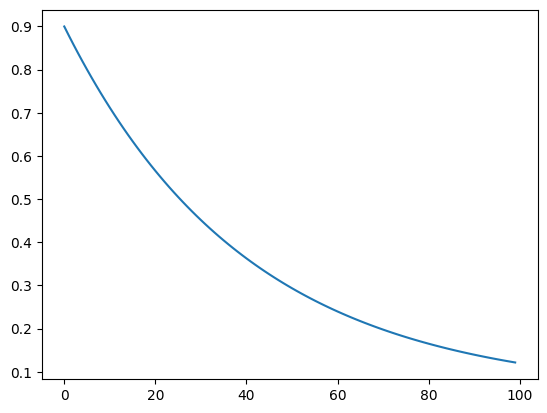

In [ ]:
plt.plot(epsilon_hist)
plt.show()

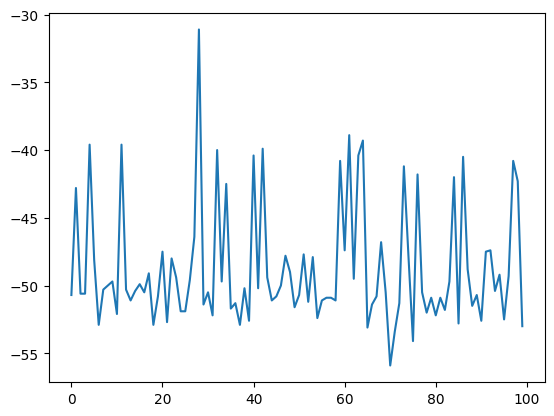

In [ ]:
plt.plot(reward_hist)
plt.show()